# Import libraries and define functions

In [1]:
!pip install glove-python-binary
from glove import Corpus, Glove
from gensim.models import Word2Vec

import numpy as np
import matplotlib.pyplot as plt

!pip install POT
import ot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 948 kB 24.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 24.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def cos_sim(a,b):
  #Compute cosine similarity of two vectors
  return np.dot(a,b) / ( np.linalg.norm(a) * np.linalg.norm(b) )

In [4]:
def get_glove_matrix(w2v,glove):
  #This function takes from gloVe model only the words which are in the w2v model vocabulary
  #and then returns the gloVe word embeddings matrix with the same word order
  
  glove_matrix = []

  for word in w2v.wv.vocab.keys():
    if word in glove.inverse_dictionary.values():
      glove_matrix.append(glove.word_vectors[list(glove.inverse_dictionary.values()).index(word)])
  
  return np.array(glove_matrix)

In [20]:
def compare(w2v,glove,bias,period,w2v_model):
  #Pass the w2v model and the glove_matrix computed with function get_glove_matrix
  #period is a string used in the plot title to identify the historical period in the considered embeddings model
  #w2v_model is a string used in the plot title to identify the w2v embeddings model (CBOW or skip-gram)
  #bias indicate if linear(False) or affine(True) mapping is used

  import random
  #Training set size
  t = 0.7
  trainlist = random.sample(range(int(len(w2v.wv.vectors))), int(t*len(w2v.wv.vectors)))
  #Test set
  testlist = [x for x in range(0,len(glove))]
  for x in trainlist:
    testlist.remove(x)

  #Prepare training sets for mapping (linear or affine)
  cbow_train = []
  glove_train = []

  for i in trainlist:
    cbow_train.append(w2v.wv.vectors[i])
    glove_train.append(glove[i])

  cbow_train = np.array(cbow_train)
  glove_train = np.array(glove_train)
###########################################################

  #Find M so that V_glove = M * V_w2v + b (b=0 se bias=False)
  M,b = ot.da.OT_mapping_linear(cbow_train, glove_train, bias=bias)
  V_glove_est = w2v.wv.vectors.dot(M) + b

###########################################################

  #Compute the cosine similarity between an embedded word in gloVe and the same word embedded in w2v and mapped in the gloVe space
  cos_sim_train = []
  cos_sim_test = []

  #Training set similarities
  for j in np.linspace(-1,0.9,20):
    count_words = 0
    for i in trainlist:
      if (cos_sim(V_glove_est[i],glove[i])<= j+0.1) and (cos_sim(V_glove_est[i],glove[i])>= j):
        count_words = count_words+1
    cos_sim_train.append(count_words)

  #Test set similarities
  for j in np.linspace(-1,0.9,20):
    count_words = 0
    for i in testlist:
      if (cos_sim(V_glove_est[i],glove[i])<= j+0.1) and (cos_sim(V_glove_est[i],glove[i])>= j):
        count_words = count_words+1
    cos_sim_test.append(count_words)

###########################################################

  #PLOT THE RESULTS

  ticks=["[-1,-0.9]","[-0.9,-0.8]","[-0.8,-0.7]","[-0.7,-0.6]","[-0.6,-0.5]","[-0.5,-0.4]","[-0.4,-0.3]","[-0.3,-0.2]","[-0.2,-0.1]","[-0.1,0]",
                            "[0,0.1]","[0.1,0.2]","[0.2,0.3]","[0.3,0.4]","[0.4,0.5]","[0.5,0.6]","[0.6,0.7]","[0.7,0.8]","[0.8,0.9]","[0.9,1]"]

  fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(16,6))
  ax[0].bar(height=cos_sim_train,x=ticks)
  ax[0].set_xticklabels(ticks,rotation = "vertical")
  ax[0].axvline(9.5,color="red",linestyle="--")
  ax[0].set_xlabel("Cosine similarity")
  ax[0].set_ylabel("N° of words")
  ax[0].set_title("Training set")

  ax[1].bar(height=cos_sim_test,x=ticks)
  ax[1].set_xticklabels(ticks,rotation = "vertical")
  ax[1].axvline(9.5,color="red",linestyle="--")
  ax[1].set_xlabel("Cosine similarity")
  ax[1].set_ylabel("N° of words")
  ax[1].set_title("Test set")

  fig.suptitle("Comparison between "+w2v_model+" mapped embeddings and GloVe ("+period+")")

  if bias==True:
    plt.savefig("/content/drive/MyDrive/DataSemantics/progetto/plots/"+w2v_model+"_"+period+"_affine.pdf")
  else:
    plt.savefig("/content/drive/MyDrive/DataSemantics/progetto/plots/"+w2v_model+"_"+period+"_linear.pdf")
  plt.show()

# Begin comparison

In [8]:
#Import w2v models
past_cbow=Word2Vec.load('/content/drive/MyDrive/DataSemantics/progetto/models/CADE/past_lem_aligned.model')
past_skip=Word2Vec.load('/content/drive/MyDrive/DataSemantics/progetto/models/CADE/past_lem_skip_aligned.model')
post_cbow=Word2Vec.load('/content/drive/MyDrive/DataSemantics/progetto/models/CADE/post_lem_aligned.model')
post_skip=Word2Vec.load('/content/drive/MyDrive/DataSemantics/progetto/models/CADE/post_lem_skip_aligned.model')

#Import gloVe models
past_glove=Glove.load('/content/drive/MyDrive/DataSemantics/progetto/models/GLOVE/glove_past_lem_centomilioni.model')
post_glove=Glove.load('/content/drive/MyDrive/DataSemantics/progetto/models/GLOVE/glove_post_lem_centomilioni.model')

In [25]:
#Compute gloVe matrices
#glove_cbow_past=get_glove_matrix(past_cbow,past_glove)
glove_cbow_post=get_glove_matrix(post_cbow,post_glove)
#glove_skip_past=get_glove_matrix(past_skip,past_glove)
glove_skip_post=get_glove_matrix(post_skip,post_glove)

#Save matrices
#np.save("/content/drive/MyDrive/DataSemantics/progetto/models/GLOVE/glove_cbow_past.npy",glove_cbow_past)
np.save("/content/drive/MyDrive/DataSemantics/progetto/models/GLOVE/glove_cbow_post.npy",glove_cbow_post)
#np.save("/content/drive/MyDrive/DataSemantics/progetto/models/GLOVE/glove_skip_past.npy",glove_skip_past)
np.save("/content/drive/MyDrive/DataSemantics/progetto/models/GLOVE/glove_skip_post.npy",glove_skip_post)

In [11]:
#Import gloVe matrices (if already computed)
glove_cbow_past=np.load("/content/drive/MyDrive/DataSemantics/progetto/models/GLOVE/glove_cbow_past.npy")
#glove_cbow_post=np.load("/content/drive/MyDrive/DataSemantics/progetto/models/GLOVE/glove_cbow_post.npy")
glove_skip_past=np.load("/content/drive/MyDrive/DataSemantics/progetto/models/GLOVE/glove_skip_past.npy")
#glove_skip_post=np.load("/content/drive/MyDrive/DataSemantics/progetto/models/GLOVE/glove_skip_post.npy")

## CBOW - GloVe (Past)

### Linear mapping

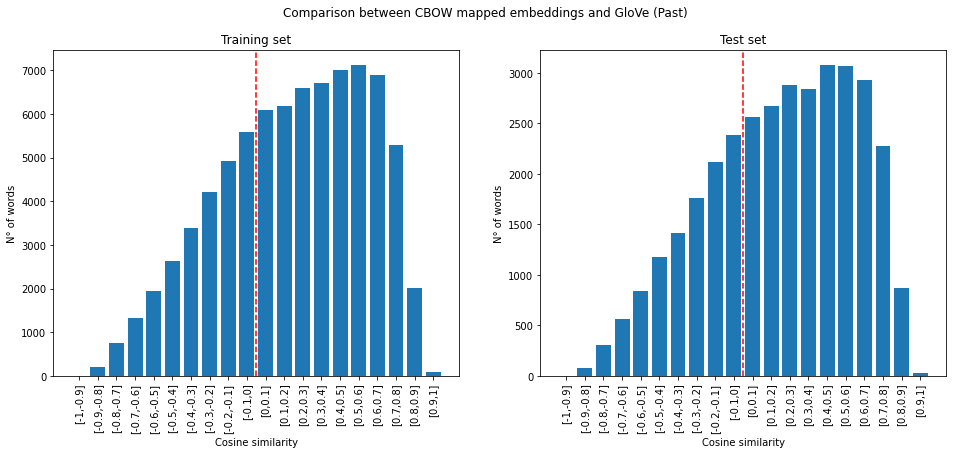

In [21]:
compare(past_cbow,glove_cbow_past,bias=False,period="Past",w2v_model="CBOW")

### Affine mapping

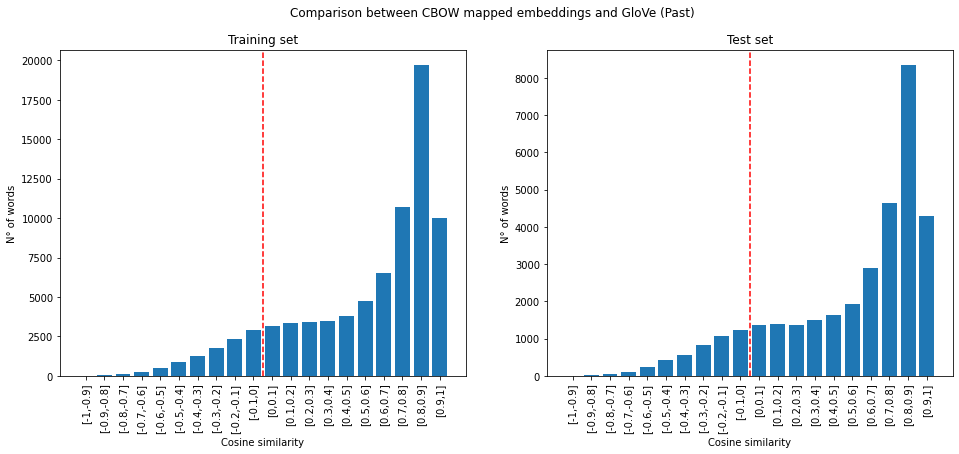

In [22]:
compare(past_cbow,glove_cbow_past,bias=True,period="Past",w2v_model="CBOW")

## CBOW - GloVe (Post)

### Linear mapping

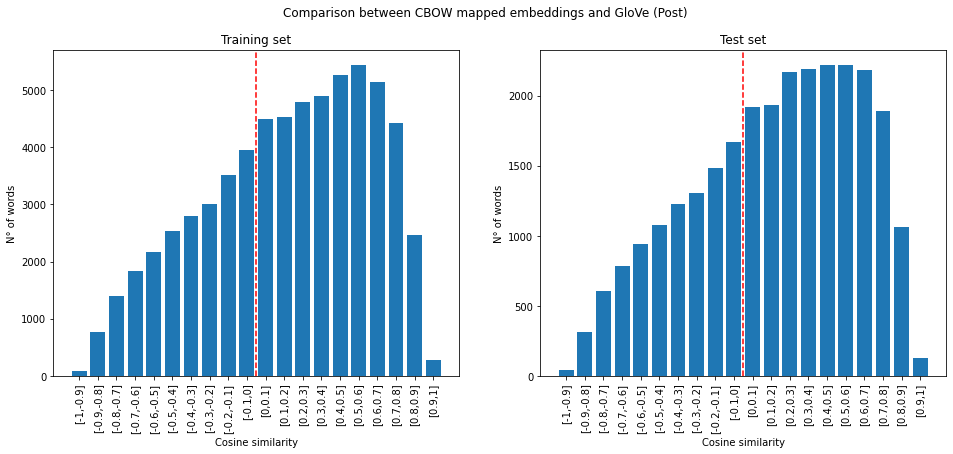

In [26]:
compare(post_cbow,glove_cbow_post,bias=False,period="Post",w2v_model="CBOW")

### Affine mapping

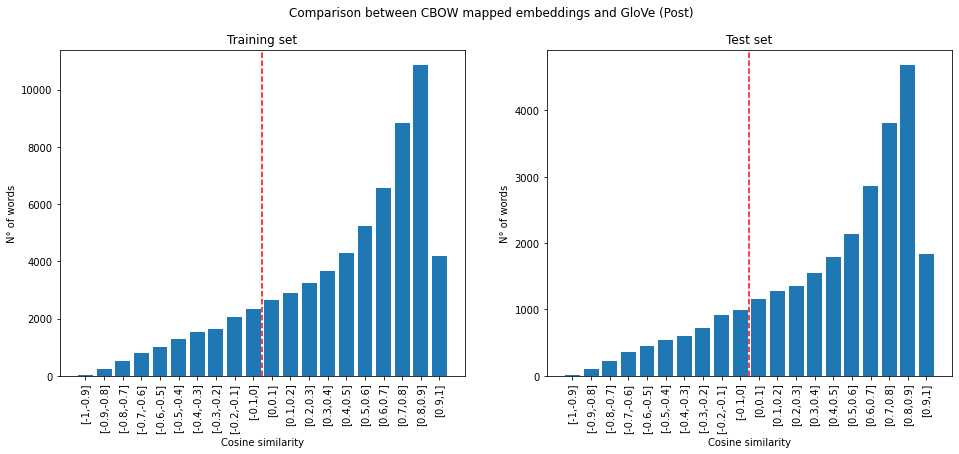

In [27]:
compare(post_cbow,glove_cbow_post,bias=True,period="Post",w2v_model="CBOW")

## Skip-gram - GloVe (Past)

### Linear mapping

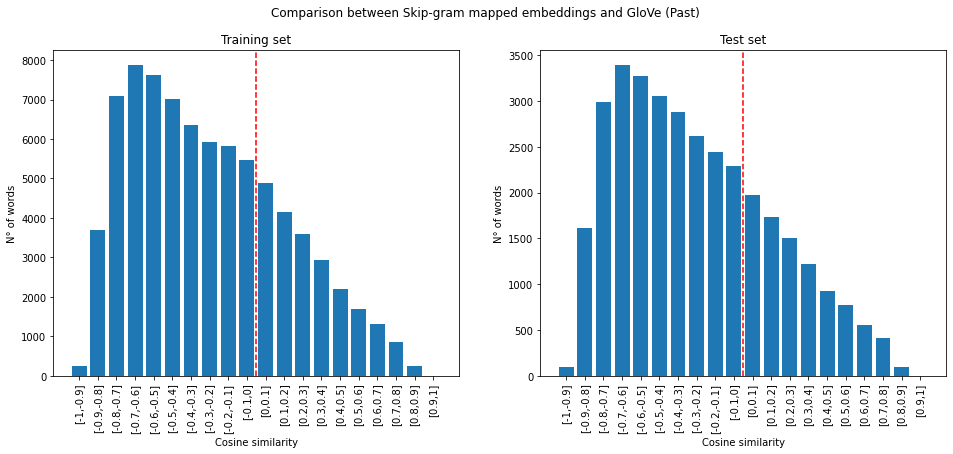

In [23]:
compare(past_skip,glove_skip_past,bias=False,period="Past",w2v_model="Skip-gram")

### Affine mapping

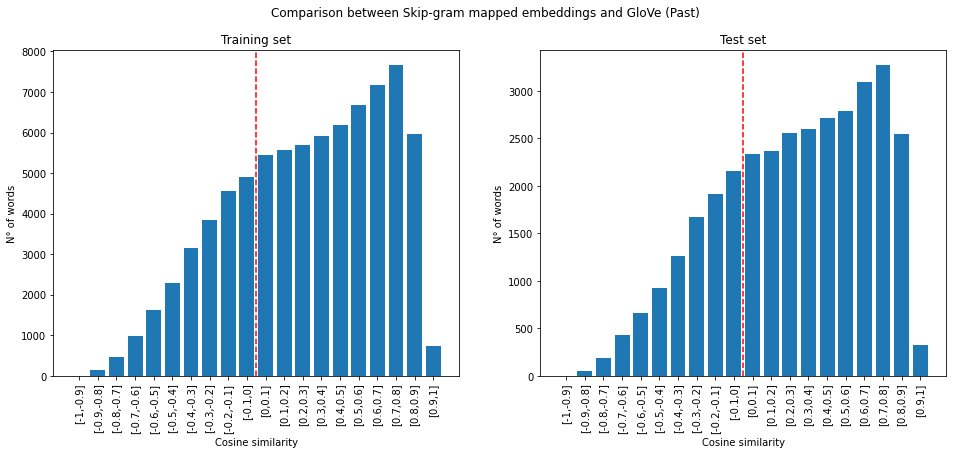

In [24]:
compare(past_skip,glove_skip_past,bias=True,period="Past",w2v_model="Skip-gram")

## Skip-gram - GloVe (Post)

### Linear mapping

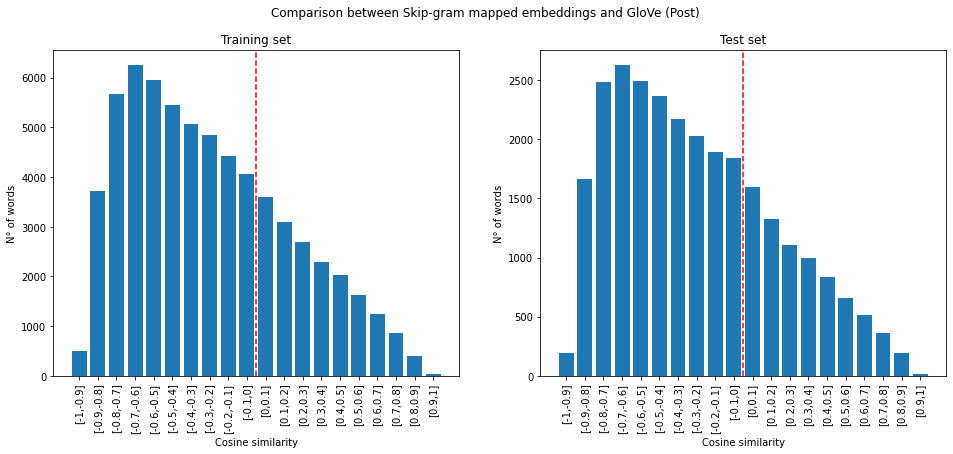

In [28]:
compare(post_skip,glove_skip_post,bias=False,period="Post",w2v_model="Skip-gram")

### Affine mapping

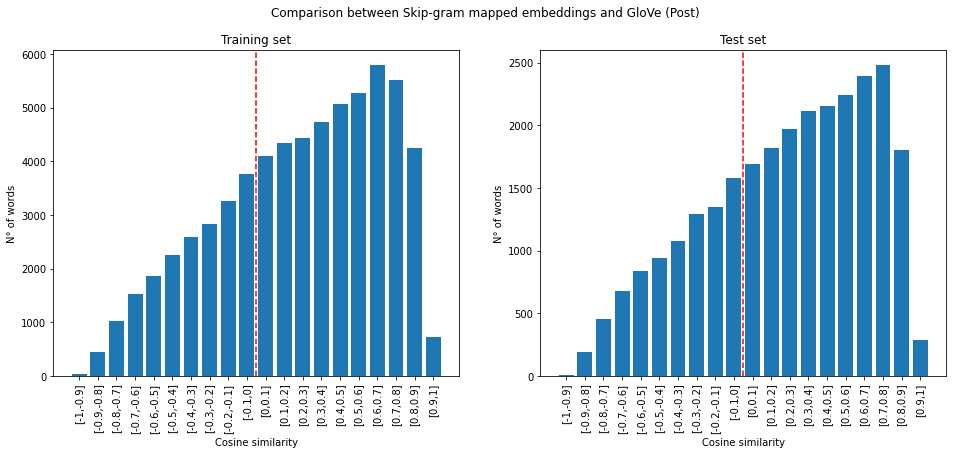

In [29]:
compare(post_skip,glove_skip_post,bias=True,period="Post",w2v_model="Skip-gram")